## Before proceeding please download the simulations trip files from https://sync.academiccloud.de/index.php/s/0FqlsyTD8BvQDtl, and extract them into ./config as they are too large to be hosted directly on GitHub

In [1]:
import numpy as np

from src.simulation.sim_core import simulation_core
from src.torch_geo.dataset.adaptive_speed2vec_dataset import adaptive_speed2vec_dataset
from src.generator.detector_node_connector import distance_connector_strategy
from src.simulation.modules.progress_module import progress_module
from src.simulation.modules.simulationFlowControlModule import simulationFlowControlModule
from src.torch_geo.model.trainer import model_train
from src.utils.math_utils import un_z_score

from torch_geometric.loader import DataLoader
from matplotlib import pyplot as plt
import torch, random, sumolib, traci

Create and set up settings

In [2]:
settings: dict = {
    # ----- framework settings -----
    "sumo_exec_path": "/home/howruck/Documents/GitHub/sumo/bin/sumo",
    "sumo_config_path": "/home/howruck/Documents/DeepSUMO/examples/celle_example_v1/config/osm.sumocfg",
    "sumo_net_path": "/home/howruck/Documents/DeepSUMO/examples/celle_example_v1/config/osm.net.xml.gz",

    # one day: 86400
    # one week: 604800
    # 777600
    # one month: 2419200
    "sim_length": 86400,  # total length of the simulation
    "interval_length": 300,  # size of one aggregation step

    # ----- model settings -----
    "N_HIST": 12,  # for Speed2Vec dataset, number of preceding steps
    "N_PRED": 9,  # for Speed2Vec dataset, number of prediction steps
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 3e-4,
    'DROPOUT': 0.6,
    'CHECKPOINT_DIR': './runs',

    'BATCH_SIZE': 50,
    'EPOCHS': 60,
    'N_NODE': 274
}
settings["total_graphs"] = int(settings["sim_length"]) // int(settings["interval_length"])

Create simulation core object and add observers

In [4]:
core = simulation_core(settings, distance_connector_strategy(50))

observer_1 = progress_module(settings["sim_length"] // 100)
observer_2 = simulationFlowControlModule(60)

core.add_continuous_observer(observer_1)
core.add_continuous_observer(observer_2)

TraCIException: Connection 'default' is already active.

Start simulation

In [5]:
core.start_simulation()

----- 2 % -----
sim_step: 1729.0
last_sim_time: 0.27 seconds
scale: 0.19476118218111899
ETA: 0.44 minutes
----- 3 % -----
sim_step: 2593.0
last_sim_time: 0.19 seconds
scale: 0.12283493984677722
ETA: 0.37 minutes
----- 4 % -----
sim_step: 3457.0
last_sim_time: 0.17 seconds
scale: 0.12724383145366921
ETA: 0.34 minutes
-----DONG, DONG, DONG-----
Passed one hour!
Day: 0 Hour: 1
Flow between 0.1 and 0.2
----- 5 % -----
sim_step: 4321.0
last_sim_time: 0.16 seconds
scale: 0.15207894867835203
ETA: 0.31 minutes
----- 6 % -----
sim_step: 5185.0
last_sim_time: 0.18 seconds
scale: 0.17445086055706635
ETA: 0.3 minutes
----- 7 % -----
sim_step: 6049.0
last_sim_time: 0.16 seconds
scale: 0.19286996803629536
ETA: 0.29 minutes
----- 8 % -----
sim_step: 6913.0
last_sim_time: 0.24 seconds
scale: 0.17934901551521523
ETA: 0.3 minutes
-----DONG, DONG, DONG-----
Passed one hour!
Day: 0 Hour: 2
Flow between 0.1 and 0.2
----- 9 % -----
sim_step: 7777.0
last_sim_time: 0.22 seconds
scale: 0.12179905421846936
ETA:

Crate dataset from data collected by DeepSUMO

In [8]:
data = adaptive_speed2vec_dataset(core.get_data(), settings["total_graphs"])
data.process()

./processed/test_data.pt
torch.Size([2, 2338])
torch.int32


Split dataset into data loaders

(287, 274)
41


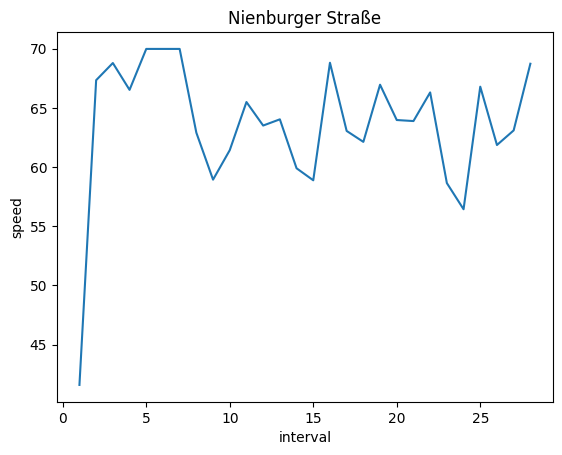

In [14]:
import numpy as np

l = []
l2 = []
buffer = []
s_id = random.randint(0, settings["N_NODE"] - 1)

print(core.get_data().numpy.get_speed_node_features().shape)
for i, point in enumerate(core.get_data().numpy.get_speed_node_features()):
    if i % 10 == 0:
        l2.append(np.average(buffer))
        buffer.clear()
    buffer.append(point[s_id] * 3.6)
    #print(point[12])
    l.append(point[s_id] * 3.6)

l = l[4:2000]

print(s_id)
sumo_id = core.get_data().translation.get_detector_id(s_id)
target_lane_id = traci.inductionloop.getLaneID(sumo_id)
target_lane: sumolib.net.lane.Lane = core.get_data().net.getLane(target_lane_id)
target_edge: sumolib.net.edge.Edge = target_lane.getEdge()

plt.title(target_edge.getName())
plt.plot(range(len(l2)), l2)
plt.xlabel("interval")
plt.ylabel("speed")
plt.show()

0, 268

In [10]:
train_threshold = int(len(data) * 0.9)
valid_threshold = int(len(data) * 0.9)
test_threshold = int(len(data) * 1.0)

train_loader = DataLoader(data[:train_threshold], shuffle=True, batch_size=settings["BATCH_SIZE"])
valid_loader = DataLoader(data[train_threshold:test_threshold], shuffle=True, batch_size=settings["BATCH_SIZE"])
test_loader = DataLoader(data[train_threshold:test_threshold], shuffle=False, batch_size=settings["BATCH_SIZE"])

Set up device

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda


Train the model

In [12]:
model = model_train(train_loader, valid_loader, settings, device)

Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 11.82it/s]


5
Train, MAE: 1.9178446531295776, RMSE: 2.5626754760742188, MAPE: 18.778873443603516
1
Valid, MAE: 1.8663870096206665, RMSE: 2.5055124759674072, MAPE: 18.44808578491211


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 102.21it/s]


5
Train, MAE: 1.5835609436035156, RMSE: 2.2540674209594727, MAPE: 15.747931480407715
1
Valid, MAE: 1.5089795589447021, RMSE: 2.1787798404693604, MAPE: 15.171223640441895


Epoch 10: 100%|██████████| 5/5 [00:00<00:00, 100.66it/s]


5
Train, MAE: 0.8028066754341125, RMSE: 1.1816445589065552, MAPE: 7.182080268859863
1
Valid, MAE: 0.6594979166984558, RMSE: 1.006309986114502, MAPE: 6.0292253494262695


Epoch 15: 100%|██████████| 5/5 [00:00<00:00, 99.62it/s]


5
Train, MAE: 0.7085402607917786, RMSE: 0.9898144602775574, MAPE: 6.370924949645996
1
Valid, MAE: 0.5689057111740112, RMSE: 0.787604033946991, MAPE: 5.334254264831543


Epoch 20: 100%|██████████| 5/5 [00:00<00:00, 101.68it/s]


5
Train, MAE: 0.674671471118927, RMSE: 0.9492215514183044, MAPE: 6.182939052581787
1
Valid, MAE: 0.5357105135917664, RMSE: 0.7560890913009644, MAPE: 5.048811912536621


Epoch 25: 100%|██████████| 5/5 [00:00<00:00, 102.12it/s]


5
Train, MAE: 0.6703566908836365, RMSE: 0.9414584040641785, MAPE: 6.130862712860107
1
Valid, MAE: 0.5318537354469299, RMSE: 0.7524464726448059, MAPE: 5.035167217254639


Epoch 30: 100%|██████████| 5/5 [00:00<00:00, 86.63it/s]


5
Train, MAE: 0.6743420958518982, RMSE: 0.9510210156440735, MAPE: 6.133368492126465
1
Valid, MAE: 0.5333175659179688, RMSE: 0.751546323299408, MAPE: 5.030238151550293


Epoch 35: 100%|██████████| 5/5 [00:00<00:00, 94.98it/s]


5
Train, MAE: 0.6678881049156189, RMSE: 0.9389925003051758, MAPE: 6.1129150390625
1
Valid, MAE: 0.5292556881904602, RMSE: 0.7491458058357239, MAPE: 5.010833740234375


Epoch 40: 100%|██████████| 5/5 [00:00<00:00, 98.90it/s]


5
Train, MAE: 0.6748794913291931, RMSE: 0.9498934149742126, MAPE: 6.125764846801758
1
Valid, MAE: 0.5323233604431152, RMSE: 0.7513497471809387, MAPE: 5.0283684730529785


Epoch 45: 100%|██████████| 5/5 [00:00<00:00, 93.79it/s]


5
Train, MAE: 0.6723002791404724, RMSE: 0.9442972540855408, MAPE: 6.117309093475342
1
Valid, MAE: 0.5279719829559326, RMSE: 0.7498889565467834, MAPE: 5.003057479858398


Epoch 50: 100%|██████████| 5/5 [00:00<00:00, 93.15it/s]


5
Train, MAE: 0.6522589921951294, RMSE: 0.9202157258987427, MAPE: 5.929640769958496
1
Valid, MAE: 0.5319094061851501, RMSE: 0.7480826377868652, MAPE: 5.017663955688477


Epoch 55: 100%|██████████| 5/5 [00:00<00:00, 95.58it/s]


5
Train, MAE: 0.6104798316955566, RMSE: 0.869861900806427, MAPE: 5.574652194976807
1
Valid, MAE: 0.5443271398544312, RMSE: 0.7539838552474976, MAPE: 5.084702014923096


Epoch 59: 100%|██████████| 5/5 [00:00<00:00, 101.19it/s]


Get predictions on testing dataset and organize them in a way, so that they can be easily plotted

In [14]:
model.eval()
model.to(device)

for i, batch in enumerate(test_loader):
    # get predictions from model
    # shape -> (batch_size * num_nodes, n_pred/n_hist)
    batch = batch.to(device)
    with torch.no_grad():
        pred = model(batch, device)
    truth = batch.y.view(pred.shape)
    
    # all values have been normalized using the z-score method,
    # so they have to be unnormalized again for evaluation
    truth = un_z_score(truth, test_loader.dataset.mean,
                       test_loader.dataset.std_dev)
    pred = un_z_score(pred, test_loader.dataset.mean,
                      test_loader.dataset.std_dev)

    truth = batch.y.view(pred.shape)
    if i == 0:
        # initialize collection variable with zeroes on first batch
        # shape -> (num_batches, batch_size * num_nodes, n_pred/n_hist)
        y_pred = torch.zeros(len(test_loader), test_loader.batch_size * settings["N_NODE"], pred.shape[1])
        y_truth = torch.zeros(len(test_loader), test_loader.batch_size * settings["N_NODE"], pred.shape[1])
    # append data from current batch to data from other batches 
    #
    # Only append until the true length of the batch in the second dimension in case
    # there are less than the max size of possible elements in the batch (can
    # only happen on the last batch)
    y_pred[i, :pred.shape[0], :] = pred
    y_truth[i, :pred.shape[0], :] = truth

# reshape into a more readable format 
# (num_batches, batch_size * num_nodes, n_pred/n_hist) 
# -> (num_intervals, n_node, n_pred/n_hist)
y_pred = y_pred.reshape(len(test_loader) * 50,
                        settings["N_NODE"], 9)
y_truth = y_truth.reshape(len(test_loader) * 50,
                          settings["N_NODE"], 9)

# cut off the last elements if there are fewer data points in the data as 
# maximum batch-size (because they are 0)
y_pred = y_pred[:len(test_loader.dataset), :, :]
y_truth = y_pred[:len(test_loader.dataset), :, :]

y_truth = un_z_score(y_truth, data.mean, data.std_dev)

Plot predictions and truth of a random detector

In [50]:


s1 = []
s2 = []
# get a random node
target = random.randint(0, settings["N_NODE"] - 1)
#print(core._data.translation.get_order())
#target = core._data.translation.get_index("98")

# get name of street associated with chosen detector
sumo_id = core.get_data().translation.get_detector_id(target)
target_lane_id = traci.inductionloop.getLaneID(sumo_id)
target_lane: sumolib.net.lane.Lane = core.get_data().net.getLane(target_lane_id)
target_edge: sumolib.net.edge.Edge = target_lane.getEdge()

for i in range(20):
    s1.append(y_pred[i][target][0])
    s2.append(y_truth[i][target][0])

print(sumo_id)
#print(y_pred[:][target])
#print(y_truth[:][target])

plt.title(target_edge.getName())
#plt.figure(figsize=(10,5), dpi=300)
plt.plot(range(20), s1, label='pred')
plt.plot(range(20), s2, label='truth')
plt.xlabel("step")
plt.ylabel("speed")
plt.legend()
plt.show()

torch.Size([25, 274, 9])


IndexError: index 98 is out of bounds for dimension 0 with size 25